# Unbinned log likelihood fitting with nllfitter


## Higgs to ZZ to 4 leptons

This is an example of estimating model parameters of a probability distribution function by minimizing the negative log likelihood (nll).  This will be carried out on dataset that was generated to simulate the discovery of the Higgs boson in the $h_{0}\rightarrow ZZ \rightarrow 4\ell$ decay channel.

In [79]:
# imports and initial set up
%cd '/home/naodell/work/projects/nllfit'
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
from scipy.stats import norm, chi2
from lmfit import Parameters

from nllfit import Parameters, ScanParameters, Model, NLLFitter
import nllfit.fit_tools as ft

/home/naodell/work/projects/nllfit


The simulated data consists two components: a background component consisting of electroweak $ZZ\rightarrow 4\ell decays$ and the signal from the Higgs boson decay.  The mixtures will be selected so as to resemble the event yields observed at CMS.

In [80]:
xlimits  = (100., 180.)
bg_data  = pd.read_csv('data/toy_hzz_bg.txt').query('{0} < inv_mass < {1}'.format(xlimits[0], xlimits[1]))
sig_data = pd.read_csv('data/toy_hzz_sig.txt').query('{0} < inv_mass < {1}'.format(115, xlimits[1]))

bg_data, sig_data = bg_data['inv_mass'].values, sig_data['inv_mass'].values
rn_bg, rn_sig     = np.random.randint(0, bg_data.size, 1000), np.random.randint(0, sig_data.size, 75)
bg_data, sig_data = bg_data[rn_bg], sig_data[rn_sig]

data = np.concatenate([bg_data[0:100], sig_data[0:25]])
#data = data[np.random.randint(0, data.size, 200)]

The number of events selected here should probably be checked to consistent with the real life scenario.  It seems like the CMS analysis uses simulation to constrain the background model.  This can be introduced by a judicious choice of simulated background events that are to be included in the fit.

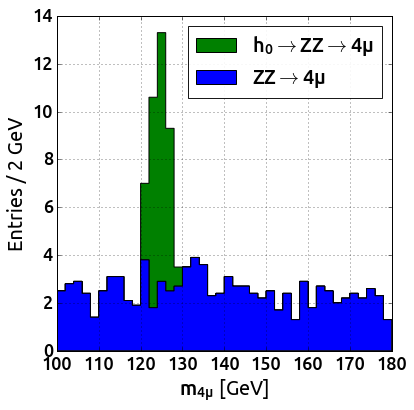

In [81]:
plt.figure(figsize=(6,6))
plt.hist([bg_data,sig_data], 
         bins     = 40, 
         range    = xlimits, 
         histtype = 'stepfilled', 
         stacked  = True, 
         weights  = [0.1*np.ones(bg_data.size), 0.4*np.ones(sig_data.size)]
        )
plt.ylabel('Entries / 2 GeV')
plt.xlabel(r'$\sf m_{4\mu}$ [GeV]')
plt.legend([r'$\sf h_{0}\rightarrow ZZ\rightarrow 4\mu$', r'$\sf ZZ\rightarrow 4\mu$'])
plt.show()

Let's define the background pdf and background plus signal datasets.

In [82]:
def bg_pdf(x, a, bnds=xlimits):                                                              
    '''                                                                        
    Third order Legendre Polynomial with constant term set to 0.5.            
                                                                               
    Parameters:                                                                
    ===========                                                                
    x: data                                                                    
    a: model parameters (a1 and a2)                                            
    '''
    z   = ft.scale_data(x, xmin=bnds[0], xmax=bnds[1])     
    fx  = legval(z, a)*2/(bnds[1] - bnds[0])        
    return fx                                                                  

def sig_pdf(x, a, normalize=False):                                            
    '''                                                                        
    Second order Legendre Polynomial (normalized to unity) plus a Gaussian.    
                                                                               
    Parameters:                                                                
    ===========                                                                
    x: data                                                                    
    a: model parameters (a1, a2, mu, and sigma)                                
    '''                                                                        
                                                                               
    bg = bg_pdf(x, a[3:])                                                     
    sig = norm.pdf(x, a[1], a[2])                                              
    if normalize:                                                              
        sig_norm = integrate.quad(lambda z: norm.pdf(z, a[1], a[2]), -1, 1)[0] 
    else:                                                                      
        sig_norm = 1.                                                          
                                                                               
    return (1 - a[0])*bg + a[0]*sig/sig_norm

For the background model (null hypothesis) we will use a third order Legendre polynomial normalized to unity (this is satisfied by requiring the coefficient for the constand term be 0.5).  The background plus signal model (alternative model) will include an additional Gaussian term.  The mean of the Gaussian should correspond to the Higgs boson mass.

Let's set up the background only fit,

In [83]:
bg_params = Parameters()
bg_params.add_many(
                   ('a0', 0.5, False, None, None, None),
                   ('a1', 0., True, None, None, None),
                   ('a2', 0., True, None, None, None),
                   ('a3', 0., True, None, None, None)
                  )

bg_model  = Model(bg_pdf, bg_params)
bg_fitter = NLLFitter(bg_model)

The NLLFitter framework uses the lmfit Parameters class.  The usage is described [here](https://lmfit.github.io/lmfit-py/parameters.html).  The Model class holds the functional form of the pdf and the parameters.  The NLLFitter is initialized with bg_model which will be used to fit to the data as follows, 

In [84]:
bg_result = bg_fitter.fit(data)

Fit finished with status: 0
[[Variables]]
    a0:   0.5 (fixed)
    a1:   0.00486009 +/- 0.067477 (1388.40%) (init= 0)
    a2:  -0.19727368 +/- 0.100684 (51.04%) (init= 0)
    a3:   0.32911675 +/- 0.109632 (33.31%) (init= 0)

[[Correlation matrix]]
[[ 1.     0.007 -0.176  0.269]
 [ 0.007  1.     0.362 -0.056]
 [-0.176  0.362  1.     0.349]
 [ 0.269 -0.056  0.349  1.   ]] 



That's all there is to it.  (N.B. the parameters are correct for the range [-1, 1], but in general won't be for the true range.  This will be addressed in iterations in the near future).  Let's do the same for the background plus signal model,

In [85]:
sig_params = Parameters()
sig_params.add_many(
                    ('A'     , 0.01 , True , 0.   , 1.   , None),
                    ('mu'    , 125  , True , 110 , 170  , None),
                    ('sigma' , 0.01 , True , 0.5 , 10.   , None),
                   )
sig_params += bg_params.copy()
sig_model  = Model(sig_pdf, sig_params)
sig_fitter = NLLFitter(sig_model)
sig_result = sig_fitter.fit(data, calculate_corr=True)

Fit finished with status: 0
[[Variables]]
    A:       0.23722834 +/- 0.049850 (21.01%) (init= 0.01)
    mu:      124.360546 +/- 0.386818 (0.31%) (init= 125)
    sigma:   1.66782449 +/- 0.287307 (17.23%) (init= 0.01)
    a0:      0.5 (fixed)
    a1:      0.15252432 +/- 0.088456 (57.99%) (init= 0)
    a2:     -0.07611351 +/- 0.122623 (161.11%) (init= 0)
    a3:      0.05832317 +/- 0.154500 (264.90%) (init= 0)

[[Correlation matrix]]
[[ 1.    -0.005  0.247 -0.247  0.147  0.16  -0.268]
 [-0.005  1.    -0.009  0.003 -0.016  0.023  0.022]
 [ 0.247 -0.009  1.    -0.146  0.087  0.093 -0.156]
 [-0.247  0.003 -0.146  1.     0.077 -0.154  0.194]
 [ 0.147 -0.016  0.087  0.077  1.     0.257 -0.049]
 [ 0.16   0.023  0.093 -0.154  0.257  1.     0.059]
 [-0.268  0.022 -0.156  0.194 -0.049  0.059  1.   ]] 



Note that I was able to just add a copy of the background parameters to the signal parameters.  Be careful to pass a copy, though, or otherwise the values in bg_params will be different after carrying out the fit of sig_model to the data.  Let's see how our fits look,

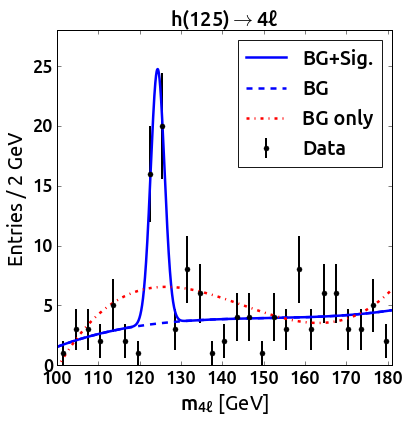

In [86]:
ft.fit_plot_1D(data, sig_model, bg_model, xlim=(100, 181), nbins=27, suffix='hzz')

Thats' a damn fine fit there.  By eye it looks pretty clear that the background plus signal fits to the data better.  The standard figure of merit for quantizing this model comparison is the likelihood ratio vis-a-vis Wilk's theorem,

In [87]:
q = 2*(bg_model.calc_nll(data) - sig_model.calc_nll(data))
print 'z = {0}'.format(np.sqrt(q))

z = 6.21948386821


Given the pseudodata was generated by injecting $\sim 5\sigma$ signal, this result is to be expected.

In [ ]:
pd.